In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats

In [2]:
# matplotlib imports
import matplotlib.pyplot as plt
import matplotlib as mpl

### set up data

In [3]:
df = pd.read_csv("titanic.csv")
df.shape
print(df.head().to_string())

   survived  pclass     sex   age  sibsp  parch     fare embarked  class    who  adult_male deck  embark_town alive  alone
0         0       3    male  22.0      1      0   7.2500        S  Third    man        True  NaN  Southampton    no  False
1         1       1  female  38.0      1      0  71.2833        C  First  woman       False    C    Cherbourg   yes  False
2         1       3  female  26.0      0      0   7.9250        S  Third  woman       False  NaN  Southampton   yes   True
3         1       1  female  35.0      1      0  53.1000        S  First  woman       False    C  Southampton   yes  False
4         0       3    male  35.0      0      0   8.0500        S  Third    man        True  NaN  Southampton    no   True


In [4]:
df["age_bin"] = pd.qcut(df["age"], q=10)
pdf = df.groupby("age_bin", observed=False, as_index=False).agg(
    **{
        "n": ("age_bin", "size"),
        "survival_rate": ("survived", "mean"),
        "survival_rate_male": (
            "survived",
            lambda x: (
                df.loc[x.index].query("sex == 'male'")["survived"].mean()
                if not x.empty
                else np.nan
            ),
        ),
        "survival_rate_female": (
            "survived",
            lambda x: (
                df.loc[x.index].query("sex == 'female'")["survived"].mean()
                if not x.empty
                else np.nan
            ),
        ),
        "mode_class": ("class", lambda x: x.value_counts().index[0]),
        "median_fare": ("fare", "median"),
        "mode_sex": ("sex", lambda x: x.value_counts().index[0]),
    }
)
print(pdf.head().to_string())

         age_bin   n  survival_rate  survival_rate_male  survival_rate_female mode_class  median_fare mode_sex
0  (0.419, 14.0]  77       0.584416            0.538462              0.631579      Third        27.75     male
1   (14.0, 19.0]  87       0.390805            0.100000              0.783784      Third        10.50     male
2   (19.0, 22.0]  67       0.283582            0.108696              0.666667      Third         8.05     male
3   (22.0, 25.0]  70       0.371429            0.136364              0.769231      Third        13.00     male
4   (25.0, 28.0]  61       0.393443            0.255814              0.722222      Third        13.00     male


In [33]:
ts = pd.read_csv("flights.csv")
ts["date"] = pd.to_datetime(
    ts["year"].astype(str) + "-" + ts["month"].astype(str) + "-01"
)
ts["n"] = ts["passengers"]
print(ts.head().to_string())
ts.shape

   year month  passengers       date    n
0  1949   Jan         112 1949-01-01  112
1  1949   Feb         118 1949-02-01  118
2  1949   Mar         132 1949-03-01  132
3  1949   Apr         129 1949-04-01  129
4  1949   May         121 1949-05-01  121


(144, 5)

In [35]:
import ta

ts["n_lag1"] = ts["n"].shift(1)
ts["n_lag3"] = ts["n"].shift(3)
ts["n_lag12"] = ts["n"].shift(12)
ts["ma12"] = ta.trend.sma_indicator(ts["n"], window=12, fillna=True)

### full example - mpl

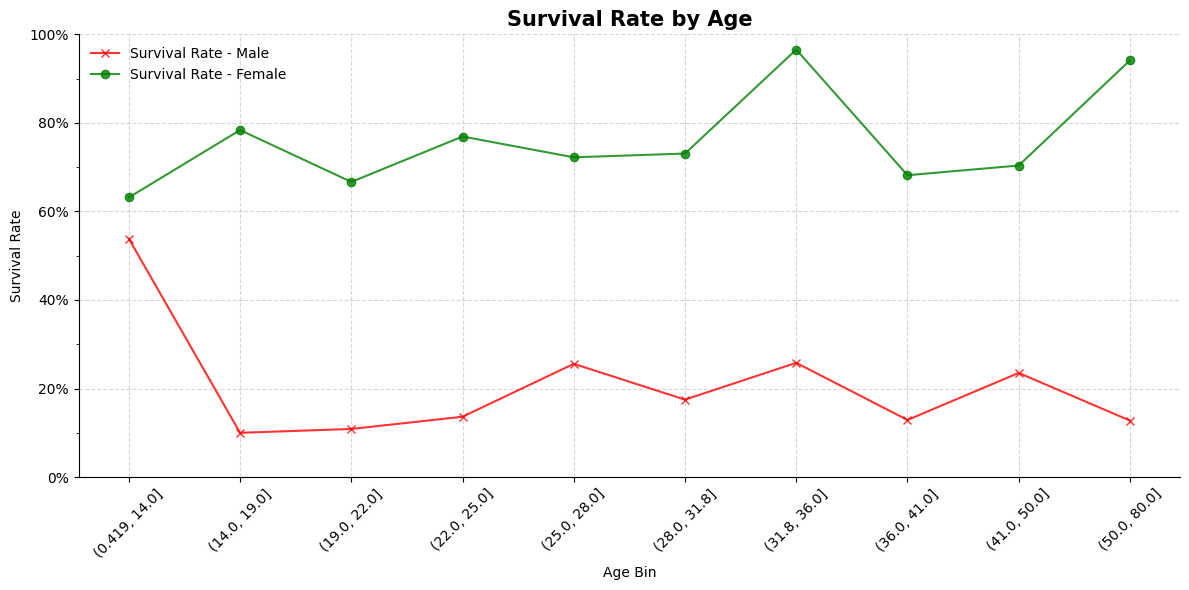

In [67]:
# line chart
fig, ax = plt.subplots(figsize=(12, 6))

ax.set_title(f"Survival Rate by Age", fontsize=15, fontweight="bold")

x_ticks = pdf["age_bin"].astype(str)

ax.plot(
    x_ticks,
    pdf["survival_rate_male"],
    alpha=0.8,
    marker="x",
    color="red",
    label="Survival Rate - Male",
)
ax.plot(
    x_ticks,
    pdf["survival_rate_female"],
    alpha=0.8,
    marker="o",
    color="green",
    label="Survival Rate - Female",
)

ax.legend(loc="upper left", fontsize=10, frameon=False)

ax.set_xlabel("Age Bin")
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_ticks, rotation=45)

ax.set_ylabel("Survival Rate")
ax.set_ylim(0, 1)
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(1.0, decimals=0))
ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))

ax.grid(True, linestyle="--", alpha=0.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()

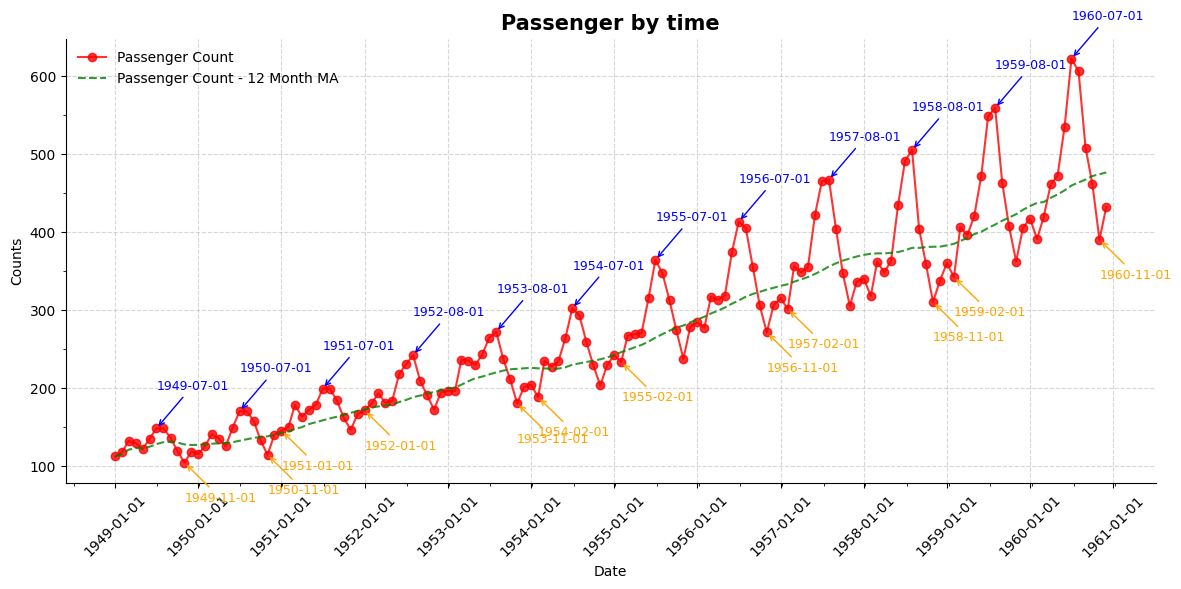

In [80]:
# ts line chart
fig, ax = plt.subplots(figsize=(12, 6))

ax.set_title(f"Passenger by time", fontsize=15, fontweight="bold")

ts["year"] = ts["date"].dt.year
ts_g = ts.groupby(["year"], dropna=False, observed=False).agg(
    **{
        "max_n": ("n", "max"),
        "max_n_date": ("n", lambda x: ts.loc[ts.loc[x.index, "n"].idxmax(), "date"]),
        "min_n": ("n", "min"),
        "min_n_date": ("n", lambda x: ts.loc[ts.loc[x.index, "n"].idxmin(), "date"]),
    }
)

ax.plot(
    ts["date"], ts["n"], alpha=0.8, marker="o", color="red", label="Passenger Count"
)
ax.plot(
    ts["date"],
    ts["ma12"],
    alpha=0.8,
    color="green",
    linestyle="--",
    label="Passenger Count - 12 Month MA",
)

for i, row in ts_g.iterrows():
    ax.annotate(
        f"{row['max_n_date'].strftime('%Y-%m-%d')}",
        xy=(row["max_n_date"], row["max_n"]),
        xytext=(row["max_n_date"], row["max_n"] + 50),
        arrowprops=dict(arrowstyle="->", color="blue"),
        fontsize=9,
        color="blue",
    )
    ax.annotate(
        f"{row['min_n_date'].strftime('%Y-%m-%d')}",
        xy=(row["min_n_date"], row["min_n"]),
        xytext=(row["min_n_date"], row["min_n"] - 50),
        arrowprops=dict(arrowstyle="->", color="orange"),
        fontsize=9,
        color="orange",
    )

ax.legend(loc="upper left", fontsize=10, frameon=False)

ax.set_xlabel("Date")
ax.xaxis.set_major_locator(mpl.dates.YearLocator())
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter("%Y-%m-%d"))
ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax.tick_params("x", rotation=45)

ax.set_ylabel("Counts")
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(100))
ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))

ax.grid(True, linestyle="--", alpha=0.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()